In [87]:
import pandas as pd
import sqlite3 

In [88]:
connection = sqlite3.connect('../data/checking-logs.sqlite')

## Данные о комитах

In [89]:
query = """
SELECT 
    timestamp,
    CAST(strftime('%w', timestamp) AS INTEGER) as weekday,
    CAST(strftime('%H', timestamp) AS INTEGER) as hour,
    date(timestamp) as date
FROM checker
WHERE uid LIKE 'user%'
"""
df = pd.read_sql(query, connection)
# df.info()

## Классификация дней на рабочие и выходные

In [90]:
df['day_type'] = 'working_day'
df.loc[df['weekday'].isin([0, 6]), 'day_type'] = 'weekend'
# df

## Подсчет коммитов по дате, типу дня и часу, затем среднее по часам

In [91]:
hourly_commits_avg = (df.groupby(['date', 'day_type', 'hour'])
              .size()
              .groupby(['day_type', 'hour'])
              .mean()
              .unstack(level=0)
              .fillna(0))

# hourly_commits_avg

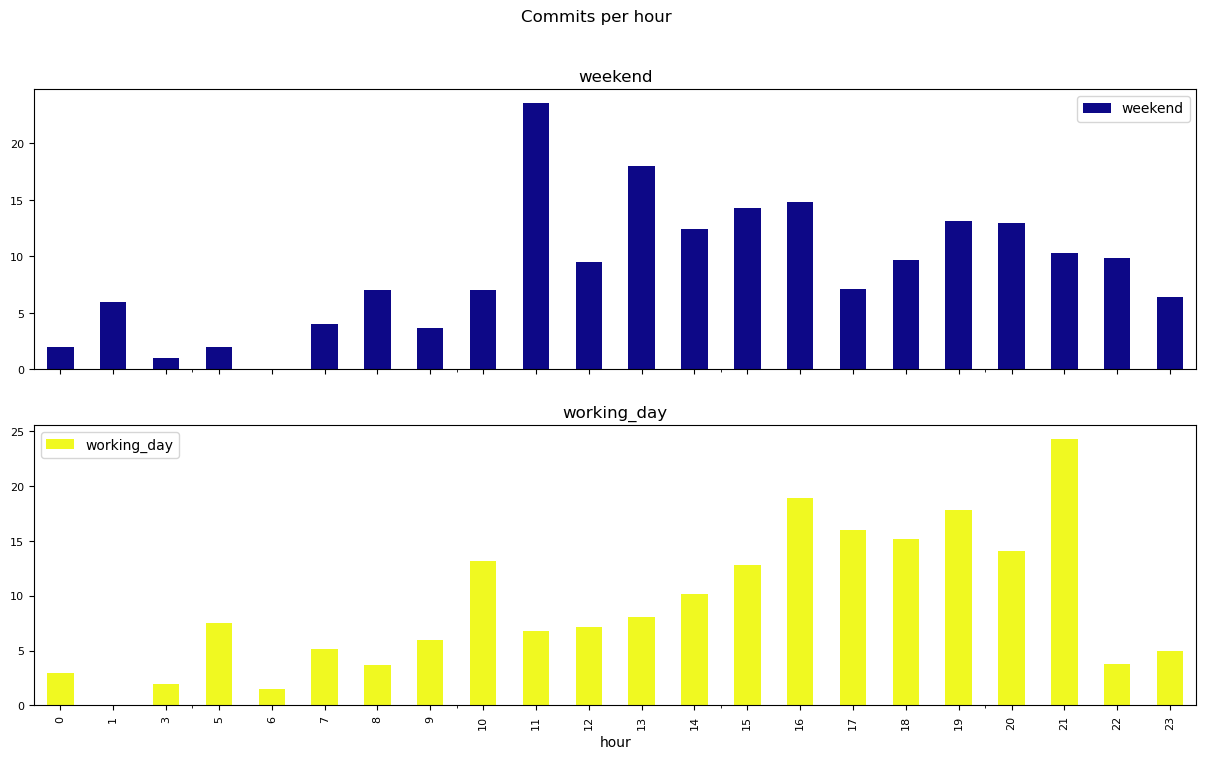

In [92]:
ax = hourly_commits_avg.plot(
    kind='bar',
    subplots=True, #разбивка на отдельные графики
    layout=(2, 1),
    figsize=(15, 8),
    colormap='plasma',
    fontsize=8,
    title='Commits per hour'
)

## Отличается ли динамика в рабочие и выходные дни?

In [93]:
max_work = hourly_commits_avg['working_day'].idxmax()
max_weekend = hourly_commits_avg['weekend'].idxmax()
print(f"Пик в рабочие дни: {max_work}:00 ({hourly_commits_avg.loc[max_work, 'working_day']:.1f} коммитов)")
print(f"Пик в выходные: {max_weekend}:00 ({hourly_commits_avg.loc[max_weekend, 'weekend']:.1f} коммитов)")

Пик в рабочие дни: 21:00 (24.3 коммитов)
Пик в выходные: 11:00 (23.6 коммитов)


## Получаем значения для 17 часа

In [94]:
hour_17_data = hourly_commits_avg.loc[17]
print(f"Рабочие дни: {hour_17_data['working_day']:.2f}")
print(f"Выходные: {hour_17_data['weekend']:.2f}")

Рабочие дни: 16.00
Выходные: 7.14


In [95]:
connection.close()